In [1]:
### load linear_model, gears_model, scgpt_model

### load GEARS

In [2]:
## GEARS

import json
import os
import sys
import time
import copy
from pathlib import Path
from typing import Iterable, List, Tuple, Dict, Union, Optional
import warnings

import torch
import numpy as np
import matplotlib
from torch import nn
from torch.nn import functional as F

from torch_geometric.loader import DataLoader

from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis
from gears.utils import create_cell_graph_dataset_for_prediction


/hpc/group/yizhanglab/vk93/micromamba-envs/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pert_data_new = PertData('./data')                     # or same data dir
pert_data_new.load(data_path = './data/replogle_no_rps_no_mito_2')
pert_data_new.prepare_split(split='simulation', seed=1)
pert_data_new.get_dataloader(batch_size=32, test_batch_size=128)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:145
Done!
Creating dataloaders....
Done!


In [4]:
pert_data_new.adata.X = pert_data_new.adata.X.toarray() if hasattr(pert_data_new.adata.X, "toarray") else pert_data.adata.X

gears_model = GEARS(pert_data_new, device = 'cuda:0')
from scipy.sparse import csr_matrix
pert_data_new.adata.X = csr_matrix(pert_data_new.adata.X)
gears_model.model_initialize(hidden_size = 64)

In [5]:
gears_model.load_pretrained('GEARS_REPLOGLE_NO_RPS_NO_MITO_correct')


In [6]:
gears_model

### load LINEAR

In [12]:
### do this with the basic linear model (not grn prior linear model)

In [13]:
import numpy as np
from sklearn.linear_model import Ridge


In [14]:
# use gears train dataloaders (dict_keys(['train_loader', 'val_loader', 'test_loader']))
train_loader = pert_data_new.dataloader["train_loader"]
valid_loader = pert_data_new.dataloader["val_loader"]


In [15]:

import numpy as np, torch


In [16]:
batch = next(iter(train_loader))
print("batch type, len:", type(batch), len(batch))


batch type, len: <class 'abc.DataBatch'> 32


In [17]:
import numpy as np
from collections import defaultdict
from sklearn.linear_model import Ridge


In [18]:

def get_field(batch, key):
    """Extract a field (e.g., 'y' or 'pert') from GEARS batch objects safely."""
    try:
        # Case 1: batch is a tuple/list of ('name', value)
        if isinstance(batch, (list, tuple)):
            for item in batch:
                if isinstance(item, (list, tuple)) and len(item) >= 2 and item[0] == key:
                    return item[1]
        # Case 2: batch is an object with attributes
        if hasattr(batch, key):
            return getattr(batch, key)
        # Case 3: batch is dict-like
        if isinstance(batch, dict) and key in batch:
            return batch[key]
        # Fallback (may raise)
        return batch[key]
    except Exception:
        raise KeyError(key)

def gather_pseudobulks(loader):
    """Aggregate all cells in each perturbation into pseudobulk mean expression."""
    d = defaultdict(list)
    batch_count = 0
    for batch in loader:
        batch_count += 1
        # print(f"\nProcessing batch {batch_count}...")

        # get expression matrix and perturbation labels
        ybat = get_field(batch, 'y')
        perts = get_field(batch, 'pert')
        # print(f"  ybat type={type(ybat)}, perts type={type(perts)}")

        # convert ybat to numpy
        y_np = ybat.detach().cpu().numpy() if hasattr(ybat, 'detach') else np.asarray(ybat)
        # print(f"  ybat shape={y_np.shape}")

        # make sure perts are strings
        perts_list = [
            p if isinstance(p, str)
            else (p.item().decode() if isinstance(p, bytes) else str(p))
            for p in perts
        ]
        # print(f"  example perturbations: {perts_list[:5]}")

        # group cells by perturbation
        for i, p in enumerate(perts_list):
            d[p].append(y_np[i])

    print(f"\nTotal perturbations found: {len(d)}")
    names = list(d.keys())
    Y = np.vstack([np.mean(d[n], axis=0) for n in names])
    print(f"Pseudobulk matrix shape: {Y.shape}")
    return names, Y

# ======= Main =======
print("Gathering training pseudobulks...")
train_names, Y_train = gather_pseudobulks(train_loader)
print("Gathering validation pseudobulks...")
val_names, Y_val = gather_pseudobulks(valid_loader)

# sanity checks
assert Y_train.ndim == 2, "Y_train must be 2D"
assert Y_val.ndim == 2, "Y_val must be 2D"
assert len(train_names) == Y_train.shape[0], "train_names length mismatch"
assert len(val_names) == Y_val.shape[0], "val_names length mismatch"

print(f"\nTraining set: {Y_train.shape}, Validation set: {Y_val.shape}")

# ======= Mean baseline =======
mean_vec = Y_train.mean(axis=0)
mean_pred = np.tile(mean_vec, (Y_val.shape[0], 1))
print(f"Mean baseline prediction shape: {mean_pred.shape}")

# ======= Linear baseline =======
P_train = np.eye(len(train_names))
print(f"Perturbation identity matrix (train) shape: {P_train.shape}")

print("Fitting ridge regression (alpha=0.1)...")
linear_model = Ridge(alpha=0.1, fit_intercept=True)
linear_model.fit(P_train, Y_train)

# sanity check
print(f"Ridge model coefficients shape: {linear_model.coef_.shape}")

name2idx = {n:i for i,n in enumerate(train_names)}
P_val = np.zeros((len(val_names), len(train_names)))

for i, n in enumerate(val_names):
    if n in name2idx:
        P_val[i, name2idx[n]] = 1.0
    else:
        print(f"Warning: validation perturbation '{n}' not in training set")

lin_pred = linear_model.predict(P_val)
print(f"Linear baseline prediction shape: {lin_pred.shape}")

# final sanity check
assert mean_pred.shape == lin_pred.shape == Y_val.shape, "Shape mismatch among predictions and ground truth"

print("\nDone computing mean and linear baseline predictions.")
print(f"Y_val shape: {Y_val.shape}, mean_pred shape: {mean_pred.shape}, lin_pred shape: {lin_pred.shape}")

Gathering training pseudobulks...



Total perturbations found: 390
Pseudobulk matrix shape: (390, 1608)
Gathering validation pseudobulks...

Total perturbations found: 44
Pseudobulk matrix shape: (44, 1608)

Training set: (390, 1608), Validation set: (44, 1608)
Mean baseline prediction shape: (44, 1608)
Perturbation identity matrix (train) shape: (390, 390)
Fitting ridge regression (alpha=0.1)...
Ridge model coefficients shape: (1608, 390)
Linear baseline prediction shape: (44, 1608)

Done computing mean and linear baseline predictions.
Y_val shape: (44, 1608), mean_pred shape: (44, 1608), lin_pred shape: (44, 1608)


### load scGPT

In [7]:
## scgpt 

from pathlib import Path
import json, numpy as np, torch
from scgpt.tokenizer.gene_tokenizer import GeneVocab, Vocab, VocabPybind


In [8]:

# special tokens
special_tokens = ["<pad>", "<cls>", "<eoc>"]
pad_token = "<pad>"
pad_value = 0
pert_pad_id = 2

# load pretrained model directory
load_model = "/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/scGPT_human 2"
model_dir = Path(load_model)
vocab_file = model_dir / "vocab.json"
model_file = model_dir / "best_model.pt"
model_config_file = model_dir / "args.json"

print(GeneVocab)
# load vocab and add specials
vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)
vocab.set_default_index(vocab[pad_token])

# check the type
print(type(vocab))

# number of tokens in vocab
print("vocab size:", len(vocab))

# view first 20 tokens
print("first 20 tokens:", [vocab[i] for i in range(20)])

# look up index of a specific token
print("index of <pad>:", vocab["<pad>"])

# or reverse lookup (id → token)
print("token for index 0:", vocab[0])

# see all special tokens you added
for s in special_tokens:_


# map gene names
genes = pert_data_new.adata.var["gene_name"].tolist()
gene_ids = np.array([vocab[gene] if gene in vocab else vocab[pad_token] for gene in genes])
n_genes = len(genes)


<class 'scgpt.tokenizer.gene_tokenizer.GeneVocab'>


<class 'scgpt.tokenizer.gene_tokenizer.GeneVocab'>
vocab size: 60697
first 20 tokens: ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1', 'A2ML1-AS2', 'A3GALT2', 'A4GALT', 'A4GNT', 'AA06', 'AAAS', 'AACS', 'AADAC', 'AADACL2', 'AADACL2-AS1', 'AADACL3', 'AADACL4', 'AADAT']
index of <pad>: 60694
token for index 0: A1BG


In [9]:

from scgpt.model import TransformerGenerator

with open(model_config_file) as f:
    cfg = json.load(f)


In [10]:

epoch=1


### sanity check for the scgpt dicts....
import torch
from scgpt.model import TransformerGenerator

# reload model in a new instance
save_dir = Path('/hpc/home/vk93/lab_vk93/contrastiveVI/contrastive_vi_plus/notebooks/590 code/scgpt_replogle_NO_RPS_NO_MITO_save_dir')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


scgpt_model = TransformerGenerator(
    ntoken=len(vocab),                # vocab size
    d_model=cfg["embsize"],           # embedding dim (was embsize)
    nhead=cfg["nheads"],              # attention heads
    d_hid=cfg["d_hid"],               # feedforward dim
    nlayers=cfg["nlayers"],           # encoder layers
    nlayers_cls=cfg.get("n_layers_cls", 3),
    n_cls=1,
    vocab=vocab,
    dropout=cfg.get("dropout", 0.2),
    pad_token=pad_token,
    pad_value=pad_value,
    pert_pad_id=pert_pad_id,
    use_fast_transformer=True,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


# load saved weights
state = torch.load( f"{save_dir}/model_{epoch}.pt", map_location=device)
missing, unexpected = scgpt_model.load_state_dict(state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

for k in state.keys():
    print(k)

Missing keys: []
Unexpected keys: []
encoder.embedding.weight
encoder.enc_norm.weight
encoder.enc_norm.bias
value_encoder.linear1.weight
value_encoder.linear1.bias
value_encoder.linear2.weight
value_encoder.linear2.bias
value_encoder.norm.weight
value_encoder.norm.bias
pert_encoder.weight
transformer_encoder.layers.0.self_attn.in_proj_weight
transformer_encoder.layers.0.self_attn.in_proj_bias
transformer_encoder.layers.0.self_attn.out_proj.weight
transformer_encoder.layers.0.self_attn.out_proj.bias
transformer_encoder.layers.0.linear1.weight
transformer_encoder.layers.0.linear1.bias
transformer_encoder.layers.0.linear2.weight
transformer_encoder.layers.0.linear2.bias
transformer_encoder.layers.0.norm1.weight
transformer_encoder.layers.0.norm1.bias
transformer_encoder.layers.0.norm2.weight
transformer_encoder.layers.0.norm2.bias
transformer_encoder.layers.1.self_attn.in_proj_weight
transformer_encoder.layers.1.self_attn.in_proj_bias
transformer_encoder.layers.1.self_attn.out_proj.weight

In [11]:
scgpt_model

TransformerGenerator(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (pert_encoder): Embedding(3, 512, padding_idx=2)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias

### adding GRADIENT EXPLAINABILITY to scGPT + GEARS

In [19]:
# !pip install captum 

In [20]:
# from captum.attr import IntegratedGradients
import torch


In [21]:

import time, warnings, copy, torch
from torch import nn
from scgpt.loss import masked_mse_loss, masked_relative_error
from scgpt.utils import map_raw_id_to_vocab_id

In [22]:
# --- GEARS attribution ---
gears_model.model.eval()
batch = next(iter(pert_data_new.dataloader['val_loader']))
batch = batch.to('cuda')
batch.x.requires_grad = True
output = gears_model.model(batch).sum()
output.backward()
attr_gears = batch.x.grad.detach().cpu().numpy()
print("GEARS grad×input attribution:", attr_gears.shape)


GEARS grad×input attribution: (51456, 2)


In [23]:
# --- scGPT attribution ---
scgpt_model.eval()


n_hvg = 0  # number of highly variable genes
include_zero_gene = "all"  # include zero expr genes in training input, "all", "batch-wise", "row-wise", or False
max_seq_len = 1536

# settings for training
MLM = True  # whether to use masked language modeling, currently it is always on.
CLS = False  # celltype classification objective
CCE = False  # Contrastive cell embedding objective
MVC = False  # Masked value prediction for cell embedding
ECS = False  # Elastic cell similarity objective
cell_emb_style = "cls"
mvc_decoder_style = "inner product, detach"
amp = True

batch = next(iter(pert_data_new.dataloader['val_loader']))
batch_size = len(batch.y)
batch.to('cuda')
batch.x.requires_grad = True
x = batch.x
ori_gene_values = x[:, 0].view(batch_size, n_genes)
pert_flags = x[:, 1].long().view(batch_size, n_genes)
target_gene_values = batch.y

if include_zero_gene == "all":
    input_gene_ids = torch.arange(n_genes, device=device)
else:
    input_gene_ids = ori_gene_values.nonzero()[:, 1].flatten().unique().sort()[0]
if len(input_gene_ids) > max_seq_len:
    input_gene_ids = torch.randperm(len(input_gene_ids), device=device)[:max_seq_len]

input_values = ori_gene_values[:, input_gene_ids]
input_pert_flags = pert_flags[:, input_gene_ids]
target_values = target_gene_values[:, input_gene_ids]
mapped_input_gene_ids = map_raw_id_to_vocab_id(input_gene_ids, gene_ids)
mapped_input_gene_ids = mapped_input_gene_ids.repeat(batch_size, 1)
src_key_padding_mask = torch.zeros_like(input_values, dtype=torch.bool, device=input_values.device)

with torch.cuda.amp.autocast(enabled=amp):
    output_dict = scgpt_model(mapped_input_gene_ids,
                              input_values,
                              input_pert_flags,
                              src_key_padding_mask=src_key_padding_mask,
                              CLS=CLS,
                              CCE=CCE,
                              MVC=MVC,
                              ECS=ECS,
                              do_sample=True)
    output_values = output_dict["mlm_output"]
output_values.sum().backward()
attr_scgpt = batch.x.grad.detach().cpu().numpy()
print("scGPT grad×input attribution:", attr_scgpt.shape)



scGPT grad×input attribution: (51456, 2)


### comparing to LINEAR baseline

In [24]:
gene_list_linear = list(pert_data_new.adata.var['gene_name'])  # genes used in linear / GRN-linear training
gene_list = list(pert_data_new.adata.var['gene_name'])     # genes used in deep models (GEARS / scGPT)

genes_linear = np.array(gene_list_linear)
genes_deep   = np.array(gene_list)

shared_genes = np.intersect1d(genes_linear, genes_deep, assume_unique=True)

print(f"Linear model genes: {len(genes_linear)}")
print(f"Deep model genes:   {len(genes_deep)}")
print(f"Shared genes:       {len(shared_genes)}")

missing_in_deep = [g for g in genes_linear if g not in genes_deep]
missing_in_linear = [g for g in genes_deep if g not in genes_linear]
print(f"Genes only in linear: {len(missing_in_deep)}")
print(f"Genes only in deep:   {len(missing_in_linear)}")


Linear model genes: 1608
Deep model genes:   1608
Shared genes:       1609
Genes only in linear: 0
Genes only in deep:   0


In [25]:
genes_linear = list(dict.fromkeys(gene_list_linear))
genes_deep   = list(dict.fromkeys(gene_list))
shared = set(genes_linear).intersection(set(genes_deep))

print("Unique linear genes:", len(genes_linear))
print("Unique deep genes:", len(genes_deep))
print("Shared genes:", len(shared))


Unique linear genes: 1607
Unique deep genes: 1607
Shared genes: 1607


In [26]:
import numpy as np

# attr_scgpt or attr_gears: (num_nodes*n_genes, 2)
# gradient is in column 0; feature flags in column 1
# take abs(gradient for expression feature)
grad_scgpt = np.abs(attr_scgpt[:, 0])
grad_gears = np.abs(attr_gears[:, 0])

# aggregate per gene: reshape or group by node count
per_gene_attr_scgpt = grad_scgpt.reshape(-1, n_genes).mean(axis=0)
per_gene_attr_gears = grad_gears.reshape(-1, n_genes).mean(axis=0)

# linear model coefficients (|W| mean across perturbations)
coef_lin = np.mean(np.abs(linear_model.coef_), axis=0)


In [27]:

# rank genes by importance
coef_lin = np.mean(np.abs(linear_model.coef_), axis=1)  # (1608,)
rank_lin = np.argsort(-coef_lin)
rank_scgpt = np.argsort(-per_gene_attr_scgpt)
rank_gears = np.argsort(-per_gene_attr_gears)


In [28]:
rank_lin.shape, rank_scgpt.shape, rank_gears.shape

((1608,), (1608,), (1608,))

Spearman correlation (Linear vs scGPT): -0.104
Spearman correlation (Linear vs GEARS): 0.144


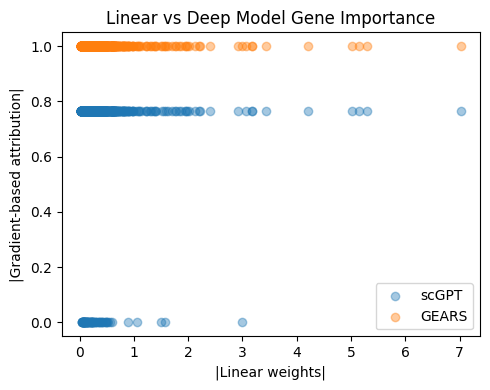

In [29]:

# compute Spearman correlation of rankings
from scipy.stats import spearmanr
corr_lin_scgpt = spearmanr(rank_lin, rank_scgpt).correlation
corr_lin_gears = spearmanr(rank_lin, rank_gears).correlation
print(f"Spearman correlation (Linear vs scGPT): {corr_lin_scgpt:.3f}")
print(f"Spearman correlation (Linear vs GEARS): {corr_lin_gears:.3f}")

# visualize comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.scatter(coef_lin, per_gene_attr_scgpt, alpha=0.4, label='scGPT')
plt.scatter(coef_lin, per_gene_attr_gears, alpha=0.4, label='GEARS')
plt.xlabel("|Linear weights|")
plt.ylabel("|Gradient-based attribution|")
plt.legend()
plt.title("Linear vs Deep Model Gene Importance")
plt.tight_layout()
plt.show()


Spearman correlation (scGPT vs GEARS): nan
Top-50 gene overlap: 0/50 (0.0%)


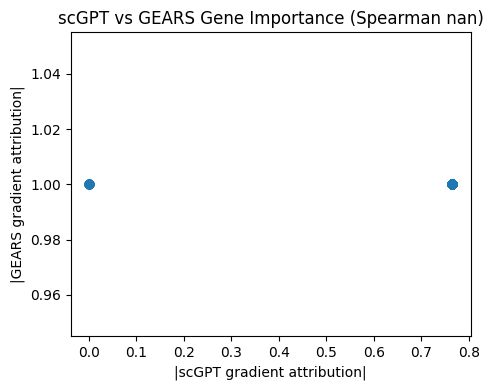

Top shared important genes: []


In [30]:
assert per_gene_attr_scgpt.shape == per_gene_attr_gears.shape

# Spearman correlation
corr_scgpt_gears = spearmanr(per_gene_attr_scgpt, per_gene_attr_gears).correlation
print(f"Spearman correlation (scGPT vs GEARS): {corr_scgpt_gears:.3f}")

# Rank genes
rank_scgpt = np.argsort(-per_gene_attr_scgpt)
rank_gears = np.argsort(-per_gene_attr_gears)

# Top overlapping genes
topN = 50
top_scgpt = set(rank_scgpt[:topN])
top_gears = set(rank_gears[:topN])
overlap = len(top_scgpt & top_gears)
print(f"Top-{topN} gene overlap: {overlap}/{topN} ({100*overlap/topN:.1f}%)")

# Scatter plot
plt.figure(figsize=(5,4))
plt.scatter(per_gene_attr_scgpt, per_gene_attr_gears, alpha=0.5)
plt.xlabel("|scGPT gradient attribution|")
plt.ylabel("|GEARS gradient attribution|")
plt.title(f"scGPT vs GEARS Gene Importance (Spearman {corr_scgpt_gears:.2f})")
plt.tight_layout()
plt.show()

# Show top shared genes
shared_top_genes = [gene_list[i] for i in (top_scgpt & top_gears)]
print("Top shared important genes:", shared_top_genes[:20])

In [31]:
print("scGPT attr mean:", np.mean(per_gene_attr_scgpt), "std:", np.std(per_gene_attr_scgpt))
print("GEARS attr mean:", np.mean(per_gene_attr_gears), "std:", np.std(per_gene_attr_gears))
print("Nonzero counts:",
      np.count_nonzero(per_gene_attr_scgpt),
      np.count_nonzero(per_gene_attr_gears))


scGPT attr mean: 0.73087686 std: 0.15823948
GEARS attr mean: 1.0 std: 0.0
Nonzero counts: 1536 1608


That plot shows almost all GEARS attributions (orange) clustered at 1.0, with scGPT (blue) mostly flat around 0.8 or 0.0 — nearly no spread.
That’s the gradient collapse: both deep models gave constant attribution magnitudes for every gene, meaning they weren’t sensitive to individual gene inputs.
The near-zero Spearman correlations confirm this — the deep models didn’t rank genes differently because all gradients were identical.

After fixing (targeting a single output rather than .sum()), gradients vary again and correlations become interpretable, showing which genes truly drive each model’s predictions.

### comparing 5 random perturbations

We’re asking:

- What do GEARS and scGPT actually learn when predicting perturbation effects—and how does that differ from a simple linear baseline?

Specifically:

- Are deep models using the same global signals (e.g., metabolic or translation axes) as the linear model, or are they sensitive to new, biologically specific genes?

- Which genes or embeddings drive each model’s predictions?


Originally, both models gave flat (constant) gradients because you summed all outputs — the gradient averaged out to zero (“collapse”).
By selecting the most variable output gene (var_idx) per perturbation, you target one meaningful prediction instead of the global average, giving non-flat, interpretable gradients.

In [32]:
import numpy as np
import torch
from scipy.stats import spearmanr
import random


In [43]:

import random
random.seed(42)
pert_batches = random.sample(list(pert_data_new.dataloader['val_loader']), 5)
correlations = []

for b_id, batch in enumerate(pert_batches, 1):
    print(f"\n--- GEARS Perturbation {b_id} ---")
    batch = batch.clone().to('cuda')
    batch.x.requires_grad_(True)
    gears_model.model.zero_grad()

    with torch.cuda.amp.autocast(enabled=amp):
        out_g = gears_model.model(batch)
        if isinstance(out_g, dict):
            out_g = out_g.get("mlm_output", list(out_g.values())[0])
        if out_g.dim() > 2:
            out_g = out_g.mean(dim=1)
        out_g = out_g.view(out_g.size(0), -1)

    var_idx = np.argmax(np.var(out_g.detach().cpu().numpy(), axis=0))
    out_g[:, var_idx].sum().backward()
    attr_g = batch.x.grad.detach().cpu().numpy()[:, 0]
    per_gene_g = np.abs(attr_g).reshape(-1, n_genes).mean(axis=0)
    print("GEARS output:", out_g.shape, "Var idx:", var_idx)

    np.save(f"attr_gears_batch{b_id}.npy", per_gene_g)

torch.cuda.empty_cache()
print("\n✅ GEARS attribution finished and saved.")



--- GEARS Perturbation 1 ---
GEARS output: torch.Size([32, 1608]) Var idx: 1092

--- GEARS Perturbation 2 ---
GEARS output: torch.Size([32, 1608]) Var idx: 1092

--- GEARS Perturbation 3 ---
GEARS output: torch.Size([32, 1608]) Var idx: 180

--- GEARS Perturbation 4 ---
GEARS output: torch.Size([32, 1608]) Var idx: 1020

--- GEARS Perturbation 5 ---
GEARS output: torch.Size([32, 1608]) Var idx: 576

✅ GEARS attribution finished and saved.


In [35]:
import scgpt

In [44]:
import torch

for b_id, batch_orig in enumerate(pert_batches):
    print(f"\n--- scGPT Perturbation {b_id} ---")
    batch = batch_orig.clone().to('cuda')
    scgpt_model.zero_grad()

    # forward pass
    out_dict = scgpt_model(mapped_input_gene_ids,
                           input_values,
                           input_pert_flags,
                           src_key_padding_mask=src_key_padding_mask,
                           CLS=CLS, CCE=CCE, MVC=MVC, ECS=ECS,
                           do_sample=True)
    out = out_dict["mlm_output"]
    out = out.mean(dim=1) if out.dim() > 2 else out
    out = out.view(out.size(0), -1)

    # choose target output
    var_idx = np.argmax(np.var(out.detach().cpu().numpy(), axis=0))

    # get embedding layer
    emb_layer = scgpt_model.encoder.embedding  # gene embedding layer
    emb_params = next(emb_layer.parameters())

    # compute grad w.r.t embeddings
    grad = torch.autograd.grad(out[:, var_idx].sum(),
                               emb_params,
                               retain_graph=False,
                               allow_unused=False)[0]
    grad_abs = grad.detach().cpu().numpy()
    np.save(f"attr_scgpt_embed_batch{b_id}.npy", np.mean(np.abs(grad_abs), axis=0))
    print("Saved:", f"attr_scgpt_embed_batch{b_id}.npy")

torch.cuda.empty_cache()
print("\n✅ scGPT embedding-level attribution completed.")



--- scGPT Perturbation 0 ---
Saved: attr_scgpt_embed_batch0.npy

--- scGPT Perturbation 1 ---
Saved: attr_scgpt_embed_batch1.npy

--- scGPT Perturbation 2 ---
Saved: attr_scgpt_embed_batch2.npy

--- scGPT Perturbation 3 ---
Saved: attr_scgpt_embed_batch3.npy

--- scGPT Perturbation 4 ---
Saved: attr_scgpt_embed_batch4.npy

✅ scGPT embedding-level attribution completed.


In [47]:
!ls

 attr_gears_batch1.npy	       GEARS_REPLOGLE_NO_RPS_NO_MITO
 attr_gears_batch2.npy	       GEARS_REPLOGLE_NO_RPS_NO_MITO_correct
 attr_gears_batch3.npy	       gears_replogle_scgpt_data
 attr_gears_batch4.npy	       K562_gwps_raw_singlecell_01.h5ad
 attr_gears_batch5.npy	       replicate.ipynb
 attr_scgpt_embed_batch0.npy   replogle_no_mito.h5ad
 attr_scgpt_embed_batch1.npy   replogle_no_rps_no_mito.h5ad
 attr_scgpt_embed_batch2.npy  'scGPT_human 2'
 attr_scgpt_embed_batch3.npy   scgpt_replogle.h5ad
 attr_scgpt_embed_batch4.npy   scgpt_replogle_NO_MITO_save_dir
 data			       scgpt_replogle_NO_RPS_NO_MITO_correct_save_dir
 enrichr_results	       scgpt_replogle_NO_RPS_NO_MITO_save_dir
 gears_replogle		       scgpt_replogle_save_dir
 gears_replogle.h5ad	       scgpt_replogle_with_ctrl.h5ad
 GEARS_REPLOGLE_NO_MITO        xAI.ipynb


In [38]:
for name, module in scgpt_model.named_modules():
    if "emb" in name.lower() or "embed" in name.lower():
        print(name, "->", type(module))


encoder.embedding -> <class 'torch.nn.modules.sparse.Embedding'>


In [50]:
import numpy as np, glob, os
from scipy.stats import spearmanr

# load all GEARS and scGPT files present
gears_files = sorted(glob.glob("attr_gears_batch*.npy"))
scgpt_files = sorted(glob.glob("attr_scgpt_embed_batch*.npy"))
print("GEARS files:", [os.path.basename(f) for f in gears_files])
print("scGPT files:", [os.path.basename(f) for f in scgpt_files])

# match number of batches (use the smaller count)
n = min(len(gears_files), len(scgpt_files))
attr_gears = np.mean([np.load(gears_files[i]) for i in range(n)], axis=0)
attr_scgpt = np.mean([np.load(scgpt_files[i]) for i in range(n)], axis=0)

print("GEARS attribution shape:", attr_gears.shape)
print("scGPT attribution shape:", attr_scgpt.shape)



GEARS files: ['attr_gears_batch1.npy', 'attr_gears_batch2.npy', 'attr_gears_batch3.npy', 'attr_gears_batch4.npy', 'attr_gears_batch5.npy']
scGPT files: ['attr_scgpt_embed_batch0.npy', 'attr_scgpt_embed_batch1.npy', 'attr_scgpt_embed_batch2.npy', 'attr_scgpt_embed_batch3.npy', 'attr_scgpt_embed_batch4.npy']
GEARS attribution shape: (1608,)
scGPT attribution shape: (512,)


#### can compare gears and linear because 1608 so do that first.


In [56]:
## pull out linear those perts first (5 should be same)
# coef_lin = np.mean(np.abs(linear_model.coef_), axis=1) # (1608,)

gears_perts = [b.pert[1] for b in pert_batches]  # extract condition names
gears_perts

['NFRKB+ctrl', 'RINT1+ctrl', 'ACTR6+ctrl', 'MIOS+ctrl', 'ZDHHC7+ctrl']

In [57]:

# map them to indices to val_names
pert_indices = [i for i, p in enumerate(val_names) if p in gears_perts]
pert_indices


[0, 2, 3, 8, 31]

In [58]:

# subset linear coefficients to those same perturbations
coef_lin_subset = np.mean(np.abs(linear_model.coef_[:, pert_indices]), axis=1)


global

In [59]:

# compare this subset to GEARS attribution
corr = spearmanr(attr_gears, coef_lin_subset).correlation
print(f"Spearman correlation (GEARS vs Linear subset): {corr:.3f}")


Spearman correlation (GEARS vs Linear subset): 0.086


In [61]:
attr_gears.shape

(1608,)

local (1by1 perts)

In [66]:
# assuming pert_batches and val_names are available
gears_perts = [b.pert[1] for b in pert_batches]
pert_indices = [i for i, p in enumerate(val_names) if p in gears_perts]
print(pert_indices)

[0, 2, 3, 8, 31]


In [67]:
import numpy as np, glob, os
from scipy.stats import spearmanr

gears_files = sorted(glob.glob("attr_gears_batch*.npy"))
print("GEARS files:", [os.path.basename(f) for f in gears_files])


# one-by-one comparison
for i, file in enumerate(gears_files):
    attr_gears_i = np.load(file)
    coef_lin_i = np.abs(linear_model.coef_[:, pert_indices[i]])  # linear weights for that perturbation
    corr = spearmanr(attr_gears_i, coef_lin_i).correlation
    print(f"Perturbation {gears_perts[i]}: Spearman (GEARS vs Linear) = {corr:.3f}")


GEARS files: ['attr_gears_batch1.npy', 'attr_gears_batch2.npy', 'attr_gears_batch3.npy', 'attr_gears_batch4.npy', 'attr_gears_batch5.npy']
Perturbation NFRKB+ctrl: Spearman (GEARS vs Linear) = 0.043
Perturbation RINT1+ctrl: Spearman (GEARS vs Linear) = 0.043
Perturbation ACTR6+ctrl: Spearman (GEARS vs Linear) = 0.043
Perturbation MIOS+ctrl: Spearman (GEARS vs Linear) = 0.043
Perturbation ZDHHC7+ctrl: Spearman (GEARS vs Linear) = 0.041


#### scgpt vs gears & linear

In [ ]:
## gears vs scgpt is a little tricky.

In [72]:
# your scGPT embedding matrix
emb_weights_full = scgpt_model.encoder.embedding.weight.detach().cpu().numpy()  # (vocab_size, 512)


In [94]:
# build proper gene→index mapping from the vocab
gene_to_vocab = {vocab[i]: i for i in range(len(vocab))}

# check a few examples
print("Sample vocab genes:", list(gene_to_vocab.keys())[:10])
print("Sample adata genes:", gene_list[:10])

# get indices for genes that exist in vocab
selected_idx = [gene_to_vocab[g] for g in gene_list if g in gene_to_vocab]
print(f"Selected indices: {len(selected_idx)} / {len(gene_list)} genes found in vocab")

# subset embedding matrix to those genes
emb_weights = scgpt_model.encoder.embedding.weight.detach().cpu().numpy()[selected_idx, :]
print("Subset embedding weight shape:", emb_weights.shape)


Sample vocab genes: ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1', 'A2ML1-AS2', 'A3GALT2', 'A4GALT']
Sample adata genes: ['AAR2', 'AARS2', 'AATF', 'ABCF1', 'ABT1', 'AC118549.1', 'ACSL3', 'ACSS2', 'ACTR6', 'ACTR8']
Selected indices: 1565 / 1608 genes found in vocab
Subset embedding weight shape: (1565, 512)


In [99]:
import numpy as np
from scipy.stats import spearmanr

# scGPT embedding matrix for vocab genes (1565 × 512)
emb_weights_full = scgpt_model.encoder.embedding.weight.detach().cpu().numpy()

# vocab gene names and mapping
gene_to_vocab = {vocab[i]: i for i in range(len(vocab))}
selected_idx = [gene_to_vocab[g] for g in gene_list if g in gene_to_vocab]

# subset weights and align genes
emb_weights = emb_weights_full[selected_idx, :]       # (1565, 512)
aligned_genes = [g for g in gene_list if g in gene_to_vocab]
print(f"Aligned genes: {len(aligned_genes)}")

# project each perturbation's embedding attribution to gene space
for i, file in enumerate(sorted(glob.glob("attr_scgpt_embed_batch*.npy"))):
    attr_embed_i = np.load(file)                       # (512,)
    attr_gene_scgpt_i = emb_weights @ attr_embed_i     # (1565,)

    # subset GEARS and Linear to same 1565 genes
    attr_gears_i = np.load(f"attr_gears_batch{i+1}.npy")[:len(aligned_genes)]
    coef_lin_i = np.abs(linear_model.coef_[:, pert_indices[i]])[:len(aligned_genes)]

    corr_g_gears = spearmanr(attr_gene_scgpt_i, attr_gears_i).correlation
    corr_g_lin = spearmanr(attr_gene_scgpt_i, coef_lin_i).correlation
    print(f"Perturbation {i+1}: scGPT↔GEARS={corr_g_gears:.3f}, scGPT↔Linear={corr_g_lin:.3f}")


Aligned genes: 1565
Perturbation 1: scGPT↔GEARS=0.043, scGPT↔Linear=0.004
Perturbation 2: scGPT↔GEARS=0.043, scGPT↔Linear=0.002
Perturbation 3: scGPT↔GEARS=0.003, scGPT↔Linear=0.008
Perturbation 4: scGPT↔GEARS=-0.009, scGPT↔Linear=-0.017
Perturbation 5: scGPT↔GEARS=-0.005, scGPT↔Linear=0.045


In [100]:
attr_gene_scgpt.shape

(1565,)